In [1]:
!python --version

Python 3.12.12


In [3]:
!pip install -q rfdetr>=1.4.0 supervision

In [ ]:
from rfdetr import RFDETRSegMedium
from rfdetr.util.coco_classes import COCO_CLASSES

model = RFDETRSegMedium()
model.optimize_for_inference()

In [4]:
import supervision as sv
from PIL import Image
import cv2

def annotate(image: Image.Image, detections: sv.Detections, classes: dict[int, str]) -> Image.Image:
    color = sv.ColorPalette.from_hex([
        "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
        "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
    ])
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)

    mask_annotator = sv.MaskAnnotator(color=color)
    polygon_annotator = sv.PolygonAnnotator(color=sv.Color.WHITE)
    label_annotator = sv.LabelAnnotator(
        color=color,
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        text_position=sv.Position.CENTER_OF_MASS
    )

    labels = [
        f"{classes.get(class_id, 'unknown')} {confidence:.2f}"
        for class_id, confidence in zip(detections.class_id, detections.confidence)
    ]

    out = image.copy()
    out = mask_annotator.annotate(out, detections)
    out = polygon_annotator.annotate(out, detections)
    out = label_annotator.annotate(out, detections, labels)
    out.thumbnail((1000, 1000))
    return out

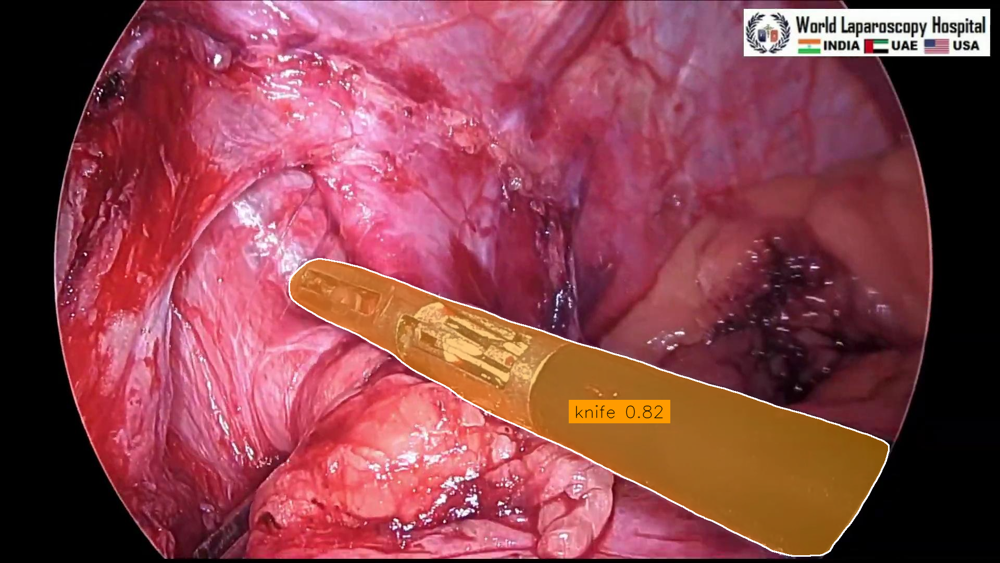

In [6]:
image_bgr = cv2.imread("/kaggle/input/sis-seg-coco/SIS-seg-coco/test/Laparoscopic-Fundoplication-17100_jpg.rf.18c931f970872a53ef2af048e73f3d79.jpg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)

detections = model.predict(image_bgr, threshold=0.3)

annotated_image = annotate(image_pil, detections, classes=COCO_CLASSES)
annotated_image

In [5]:
import json
import os
import shutil

# 1. Define paths
src_dataset = "/kaggle/input/sis-seg-coco/SIS-seg-coco"
dst_dataset = "/kaggle/working/SIS-seg-coco"

# 2. Mirror the entire directory structure and files
if os.path.exists(dst_dataset):
    shutil.rmtree(dst_dataset) # Start fresh if it exists

print(f"Mirroring dataset to {dst_dataset}...")
shutil.copytree(src_dataset, dst_dataset, dirs_exist_ok=True)

# 3. Patch JSON files to fix 'supercategory' error
print("Patching COCO JSON files...")
for root, _, files in os.walk(dst_dataset):
    for file in files:
        if file.endswith(".json"):
            file_path = os.path.join(root, file)
            
            with open(file_path, 'r') as f:
                data = json.load(f)
            
            # Inject 'supercategory' if missing (required by rfdetr)
            updated = False
            for category in data.get('categories', []):
                if 'supercategory' not in category:
                    category['supercategory'] = 'none' # rfdetr specifically checks if this != "none"
                    updated = True
            
            if updated:
                with open(file_path, 'w') as f:
                    json.dump(data, f)
                print(f"  Fixed: {file}")

print("Dataset is ready in /kaggle/working/SIS-seg-coco")

Mirroring dataset to /kaggle/working/SIS-seg-coco...
Patching COCO JSON files...
  Fixed: _annotations.coco.json
  Fixed: _annotations.coco.json
  Fixed: _annotations.coco.json
Dataset is ready in /kaggle/working/SIS-seg-coco


In [6]:
import json
import os

dataset_path = "/kaggle/working/SIS-seg-coco"

for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".json"):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                data = json.load(f)
            
            # 1. Map IDs and set supercategory to 'dataset'
            categories = sorted(data.get('categories', []), key=lambda x: x['id'])
            id_map = {cat['id']: i for i, cat in enumerate(categories)}
            
            new_categories = []
            for cat in categories:
                cat['id'] = id_map[cat['id']]
                # CRITICAL: Must NOT be "none" for rfdetr to count it
                cat['supercategory'] = 'dataset' 
                new_categories.append(cat)
            
            data['categories'] = new_categories

            # 2. Update Annotations
            for ann in data.get('annotations', []):
                ann['category_id'] = id_map[ann['category_id']]
            
            with open(file_path, 'w') as f:
                json.dump(data, f)
                
            print(f"Patched {file}: Found {len(new_categories)} classes.")

Patched _annotations.coco.json: Found 6 classes.
Patched _annotations.coco.json: Found 6 classes.
Patched _annotations.coco.json: Found 6 classes.


In [9]:
import json
import os

dataset_path = "/kaggle/working/SIS-seg-coco"

for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".json"):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                data = json.load(f)
            
            # Add the missing 'info' key for pycocotools
            if 'info' not in data:
                data['info'] = {
                    "description": "Fixed COCO dataset",
                    "version": "1.0",
                    "year": 2024,
                    "contributor": "Kaggle",
                    "date_created": "2024-01-01"
                }
            
            with open(file_path, 'w') as f:
                json.dump(data, f)
            print(f"Added 'info' header to: {file}")

Added 'info' header to: _annotations.coco.json
Added 'info' header to: _annotations.coco.json
Added 'info' header to: _annotations.coco.json


In [7]:
from rfdetr import RFDETRSegMedium

model = RFDETRSegMedium()

2026-02-01 14:02:53.633401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769954573.795965      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769954573.844160      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769954574.229571      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769954574.229611      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769954574.229614      55 computation_placer.cc:177] computation placer alr

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 12 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


In [10]:
model.train(dataset_dir="/kaggle/working/SIS-seg-coco", epochs=5, batch_size=2, grad_accum_steps=4)

fatal: not a git repository (or any of the parent directories): .git


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=7, grad_accum_steps=4, print_freq=10, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=2, weight_decay=0.0001, epochs=5, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-seg-medium.pt', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=5, dim_feedforward=2048, hidden_dim=256, sa_nh

Epoch: [0]  [  0/356]  eta: 0:19:28  lr: 0.000100  class_error: 64.10  loss: 34.7957 (34.7957)  loss_ce: 4.2793 (4.2793)  loss_bbox: 0.3211 (0.3211)  loss_giou: 0.2263 (0.2263)  loss_mask_ce: 0.2460 (0.2460)  loss_mask_dice: 0.2507 (0.2507)  loss_ce_0: 5.5288 (5.5288)  loss_bbox_0: 0.2964 (0.2964)  loss_giou_0: 0.2828 (0.2828)  loss_mask_ce_0: 0.2263 (0.2263)  loss_mask_dice_0: 0.2576 (0.2576)  loss_ce_1: 4.5326 (4.5326)  loss_bbox_1: 0.3486 (0.3486)  loss_giou_1: 0.3063 (0.3063)  loss_mask_ce_1: 0.2412 (0.2412)  loss_mask_dice_1: 0.2549 (0.2549)  loss_ce_2: 4.3945 (4.3945)  loss_bbox_2: 0.3547 (0.3547)  loss_giou_2: 0.2534 (0.2534)  loss_mask_ce_2: 0.2249 (0.2249)  loss_mask_dice_2: 0.2283 (0.2283)  loss_ce_3: 4.5613 (4.5613)  loss_bbox_3: 0.3296 (0.3296)  loss_giou_3: 0.2423 (0.2423)  loss_mask_ce_3: 0.2271 (0.2271)  loss_mask_dice_3: 0.2367 (0.2367)  loss_ce_enc: 4.5353 (4.5353)  loss_bbox_enc: 0.5246 (0.5246)  loss_giou_enc: 0.4973 (0.4973)  loss_mask_ce_enc: 0.2891 (0.2891)  loss_

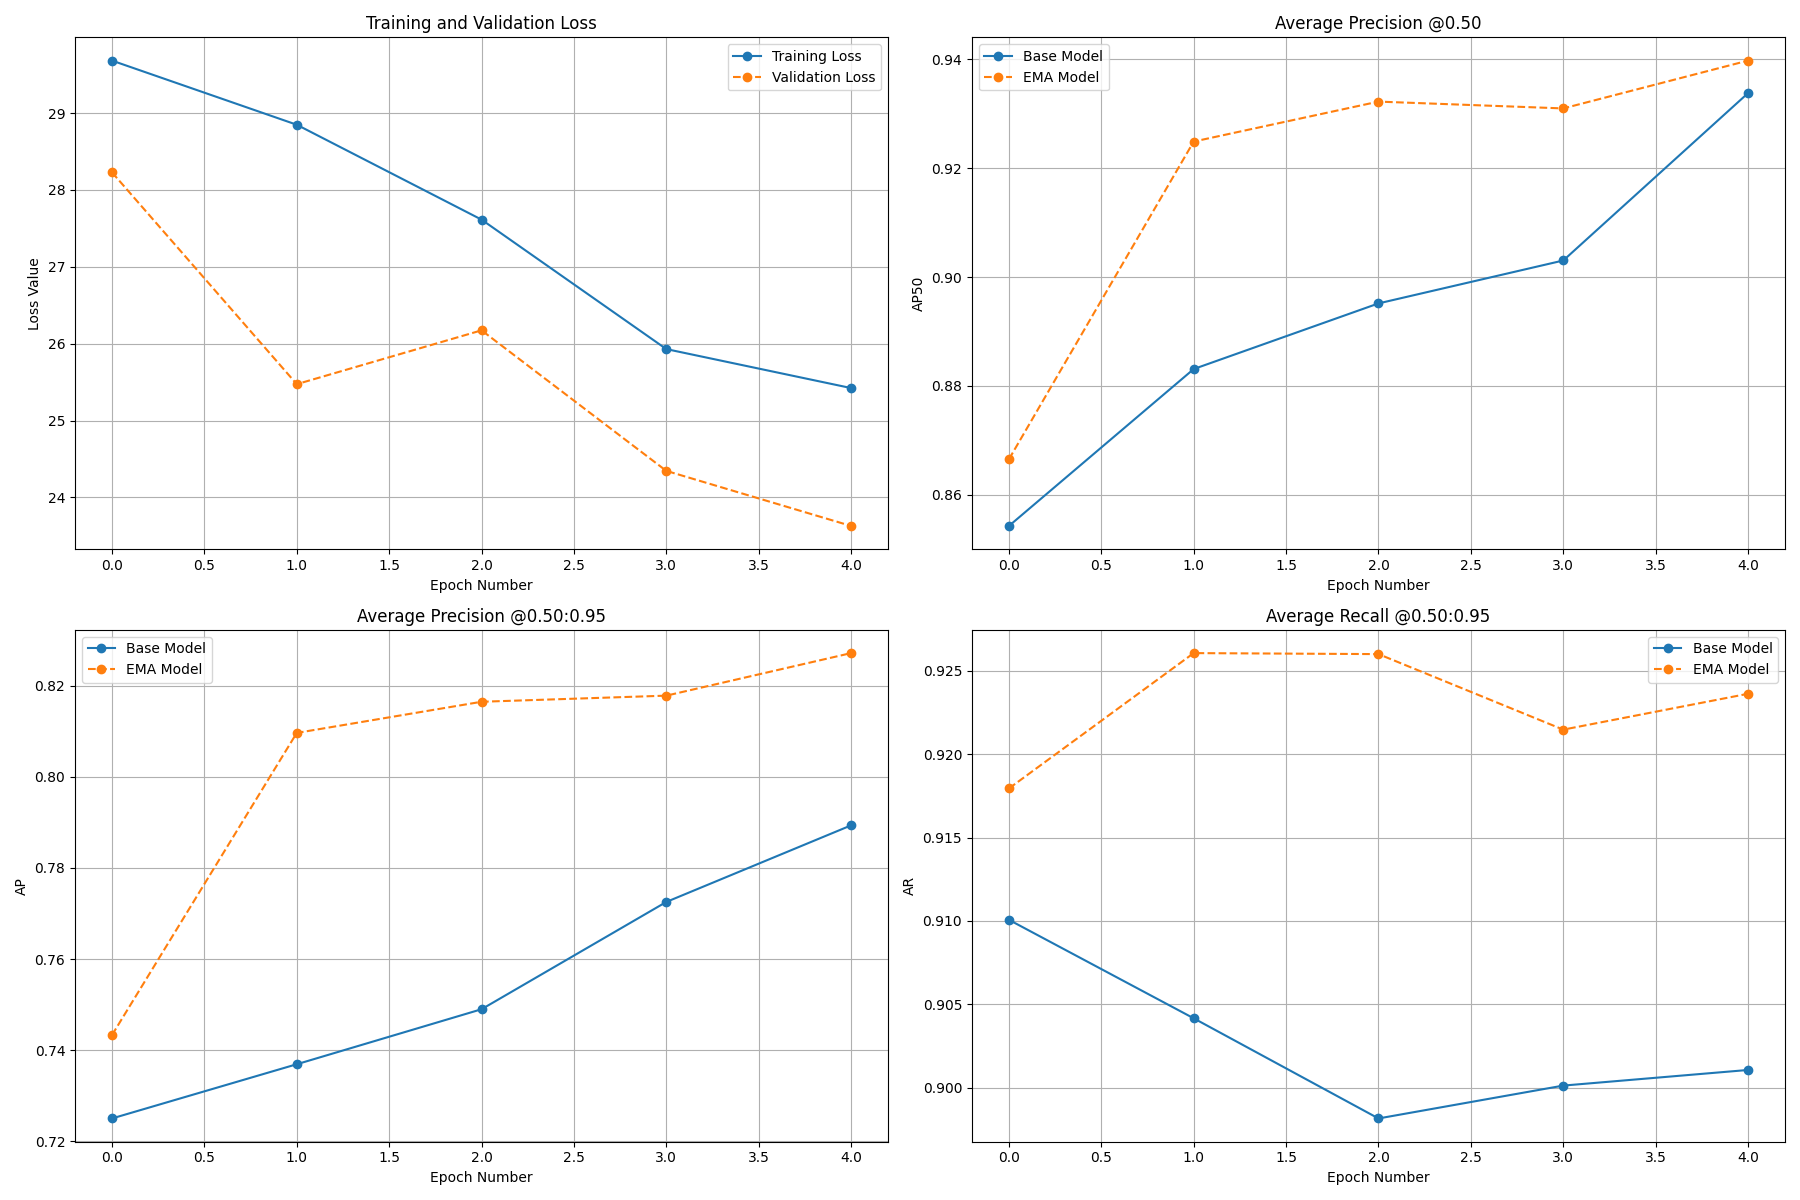

In [11]:
Image.open("/kaggle/working/output/metrics_plot.png")

In [12]:
import gc
import torch
import weakref

def cleanup_gpu_memory(obj=None, verbose: bool = False):

    if not torch.cuda.is_available():
        if verbose:
            print("[INFO] CUDA is not available. No GPU cleanup needed.")
        return

    def get_memory_stats():
        allocated = torch.cuda.memory_allocated()
        reserved = torch.cuda.memory_reserved()
        return allocated, reserved

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[Before] Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

    # Ensure we drop all strong references
    if obj is not None:
        ref = weakref.ref(obj)
        del obj
        if ref() is not None and verbose:
            print("[WARNING] Object not fully garbage collected yet.")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[After]  Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

In [13]:
cleanup_gpu_memory(model, verbose=True)

[Before] Allocated: 946.63 MB | Reserved: 13258.00 MB
[WARNING] Object not fully garbage collected yet.
[After]  Allocated: 946.63 MB | Reserved: 1034.00 MB


In [37]:
from rfdetr import RFDETRSegMedium
model = RFDETRSegMedium(pretrain_weights="/kaggle/working/output/checkpoint_best_total.pth")
model.optimize_for_inference()

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 12 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.


Loading pretrain weights


In [15]:
import supervision as sv

ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=f"/kaggle/working/SIS-seg-coco/test",
    annotations_path=f"/kaggle/working/SIS-seg-coco/test/_annotations.coco.json",
    force_masks=True
)

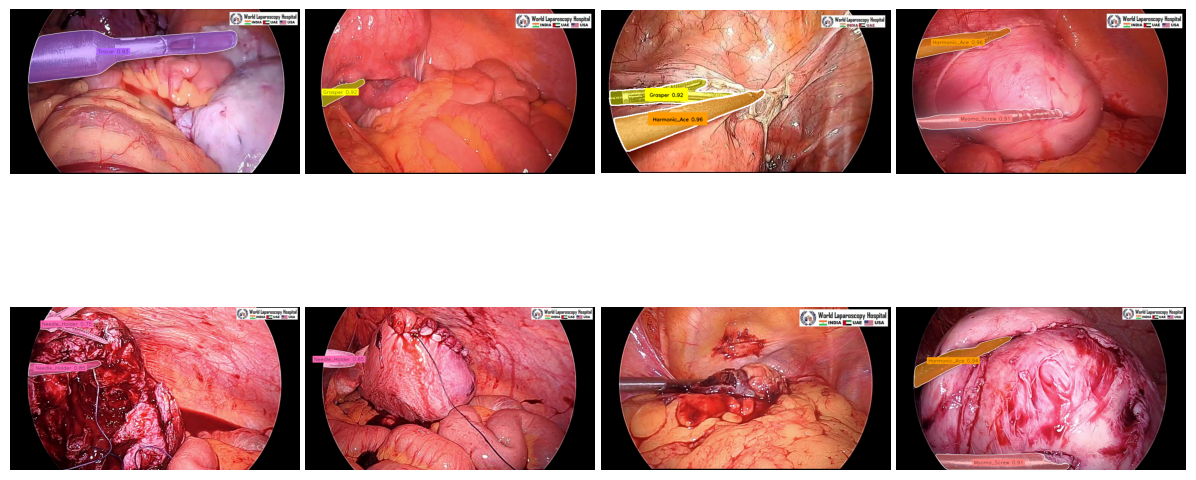

In [17]:
import random
import matplotlib.pyplot as plt

N = 8
L = len(ds_test)

annotated_images = []

for i in random.sample(range(L), N):
    path, _, annotations = ds_test[i]
    image = Image.open(path)
    detections = model.predict(image, threshold=0.5)
    annotated_image = annotate(image, detections, classes={i: class_name for i, class_name in enumerate(ds_test.classes)})
    annotated_images.append(annotated_image)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for ax, img in zip(axes.flat, annotated_images):
    ax.imshow(img)
    ax.axis("off")

plt.subplots_adjust(wspace=0.02, hspace=0.02, left=0.01, right=0.99, top=0.99, bottom=0.01)
plt.show()

In [ ]:
!pip install rfdetr[onnxexport]

In [ ]:
!pip install --force-reinstall onnx==1.16.1

In [20]:
import torch
print(torch.__version__)

2.8.0+cu126


In [ ]:
!pip install --upgrade rfdetr

In [40]:
# Then, try to export the model again.
model.export()

Exporting model to ONNX format
PyTorch inference output shapes - Boxes: torch.Size([1, 200, 4]), Labels: torch.Size([1, 200, 7]), Masks: torch.Size([1, 200, 108, 108])

Successfully exported ONNX model: output/inference_model.onnx
Successfully exported ONNX model to: output/inference_model.onnx
ONNX export completed successfully


In [78]:
import onnxruntime
import numpy as np
import cv2
import torch

img_path = "/kaggle/input/sis-seg-coco/SIS-seg-coco/train/Laparoscopic-Fundoplication-10980_jpg.rf.426bd1153352271e359e228996139a32.jpg"

img = cv2.imread(img_path)

if img is None:
    raise FileNotFoundError(f"Image not found at {img_path}")

img_resized = cv2.resize(img, (432, 432))
img_input = img_resized.astype(np.float32) / 255.0
img_input = img_input.transpose(2, 0, 1)[np.newaxis, :]  # (1, 3, H, W)

# Run inference
session = onnxruntime.InferenceSession("/kaggle/working/output/inference_model.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: img_input})

print("Output:", [o.shape for o in outputs])

out0 = outputs[0]
out1 = outputs[1]
out2 = outputs[2]

print("out0 shape:", out0.shape)
print("out1 shape:", out1.shape)
print("out2 shape:", out2.shape)

# inspect ONE prediction row
row = out0[0, 0]
print("one row length:", row.shape[0])
print("first 10 values:", row[:10])
print("last 40 values:", row[-40:])

row = out1[0, 0]
print("one row length:", row.shape[0])
print("first 10 values:", row[:10])
print("last 40 values:", row[-40:])

row = out2[0, 0]
print("one row length:", row.shape[0])
print("first 10 values:", row[:10])
print("last 40 values:", row[-40:])

Output: [(1, 200, 4), (1, 200, 7), (1, 200, 108, 108)]
out0 shape: (1, 200, 4)
out1 shape: (1, 200, 7)
out2 shape: (1, 200, 108, 108)
one row length: 4
first 10 values: [0.15501817 0.4884806  0.08791869 0.08503157]
last 40 values: [0.15501817 0.4884806  0.08791869 0.08503157]
one row length: 7
first 10 values: [-5.132369  -5.969551  -6.2769203 -6.1080017 -6.412839  -6.158888
 -7.5331597]
last 40 values: [-5.132369  -5.969551  -6.2769203 -6.1080017 -6.412839  -6.158888
 -7.5331597]
one row length: 108
first 10 values: [[-21.54346  -19.629992 -20.18065  ... -22.11022  -21.196873 -22.941145]
 [-23.716597 -17.091536 -17.240465 ... -15.323725 -13.414214 -20.947088]
 [-23.208405 -19.679678 -20.876764 ... -20.695473 -13.791705 -22.693441]
 ...
 [-25.255352 -21.644562 -22.16254  ... -18.982939 -14.39005  -23.53462 ]
 [-25.258017 -21.205896 -21.928442 ... -19.26289  -15.262994 -23.184795]
 [-25.144308 -21.36693  -22.17646  ... -20.004873 -17.101164 -23.337687]]
last 40 values: [[-25.97654  -21.

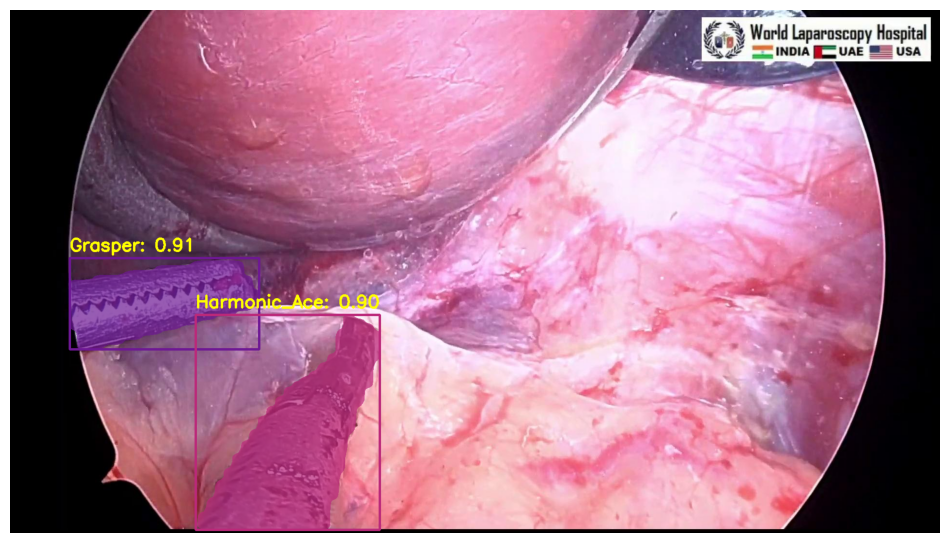

In [83]:
import onnxruntime
import numpy as np
import cv2
import matplotlib.pyplot as plt

MODEL_PATH = "/kaggle/working/output/inference_model.onnx"
IMG_PATH = "/kaggle/input/sis-seg-coco/SIS-seg-coco/train/Laparoscopic-Fundoplication-10980_jpg.rf.426bd1153352271e359e228996139a32.jpg"

THRESHOLD = 0.3
IOU_THRESHOLD = 0.3

CLASS_NAMES = ['bg', 'Grasper', 'Harmonic_Ace', 'Myoma_Screw', 'Needle_Holder', 'Suction', 'Trocar']

# Create a list of colors for each class where each color is a tuple of 3 integer values
rng = np.random.default_rng(3)
colors = rng.uniform(0, 255, size=(len(CLASS_NAMES), 3))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# -------------------------------------------------
# 1. LOAD IMAGE
# -------------------------------------------------
image_bgr = cv2.imread(IMG_PATH)
if image_bgr is None:
    raise FileNotFoundError(IMG_PATH)
h_orig, w_orig = image_bgr.shape[:2]

# -------------------------------------------------
# 2. PREPROCESS
# -------------------------------------------------
img_resized = cv2.resize(image_bgr, (432, 432))
img = img_resized.astype(np.float32) / 255.0
img = img.transpose(2, 0, 1)[None]

# -------------------------------------------------
# 3. INFERENCE
# -------------------------------------------------
session = onnxruntime.InferenceSession(
    MODEL_PATH, providers=["CPUExecutionProvider"]
)
out_boxes, out_logits, out_masks = session.run(
    None, {session.get_inputs()[0].name: img}
)

out_boxes = out_boxes[0]     # (200,4) cx,cy,w,h normalized
out_logits = out_logits[0]   # (200,2) raw logits
out_masks = out_masks[0]     # (200,108,108) raw logits

# -------------------------------------------------
# 4. ✅ CORRECT SCORING
# -------------------------------------------------
# sigmoid per class (multi-label head)
cls_probs = sigmoid(out_logits)        # (200,7)

labels = np.argmax(cls_probs, axis=1) + 1
scores = np.max(cls_probs, axis=1)

valid = np.where(scores > THRESHOLD)[0]

# DETR-style fallback
if len(valid) == 0:
    valid = np.argsort(scores)[-5:][::-1]

# -------------------------------------------------
# 5. BOX DECODE (NORMALIZED → IMAGE SPACE)
# -------------------------------------------------
boxes_nms = []
scores_nms = []
labels_nms = []

for idx in valid:
    cx, cy, w, h = out_boxes[idx]

    x1 = (cx - w / 2) * w_orig
    y1 = (cy - h / 2) * h_orig
    bw = w * w_orig
    bh = h * h_orig

    boxes_nms.append([float(x1), float(y1), float(bw), float(bh)])
    scores_nms.append(float(scores[idx]))
    labels_nms.append(int(labels[idx]))

# -------------------------------------------------
# 6. NMS
# -------------------------------------------------
keep = cv2.dnn.NMSBoxes(
    boxes_nms,
    scores_nms,
    THRESHOLD,
    IOU_THRESHOLD
)

# -------------------------------------------------
# 7. DRAW
# -------------------------------------------------
overlay = image_bgr.copy()

if len(keep) > 0:
    for i in keep.flatten():
        idx = valid[i]
        score = scores_nms[i]

        x, y, bw, bh = boxes_nms[i]
        x1, y1 = max(0, int(x)), max(0, int(y))
        x2 = min(w_orig, int(x + bw))
        y2 = min(h_orig, int(y + bh))

        # mask
        m = sigmoid(out_masks[idx])
        m = cv2.resize(m, (w_orig, h_orig))
        m = m > 0.3

        bbox_mask = np.zeros_like(m, dtype=bool)
        bbox_mask[y1:y2, x1:x2] = True
        m = np.logical_and(m, bbox_mask)

        if m.sum() < 0.01 * (bw * bh):
            continue

        cls_id = labels_nms[i]
        cls_name = CLASS_NAMES[cls_id]
        color = colors[cls_id]

        overlay[m] = (
            overlay[m].astype(np.float32) * 0.3 +
            np.array([color], dtype=np.float32) * 0.7
        ).astype(np.uint8)

        cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 3)
        cv2.putText(overlay, f"{cls_name}: {score:.2f}", (x1, y1 - 15), cv2.FONT_HERSHEY_SIMPLEX,
            1.2, (0, 255, 255), 3)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

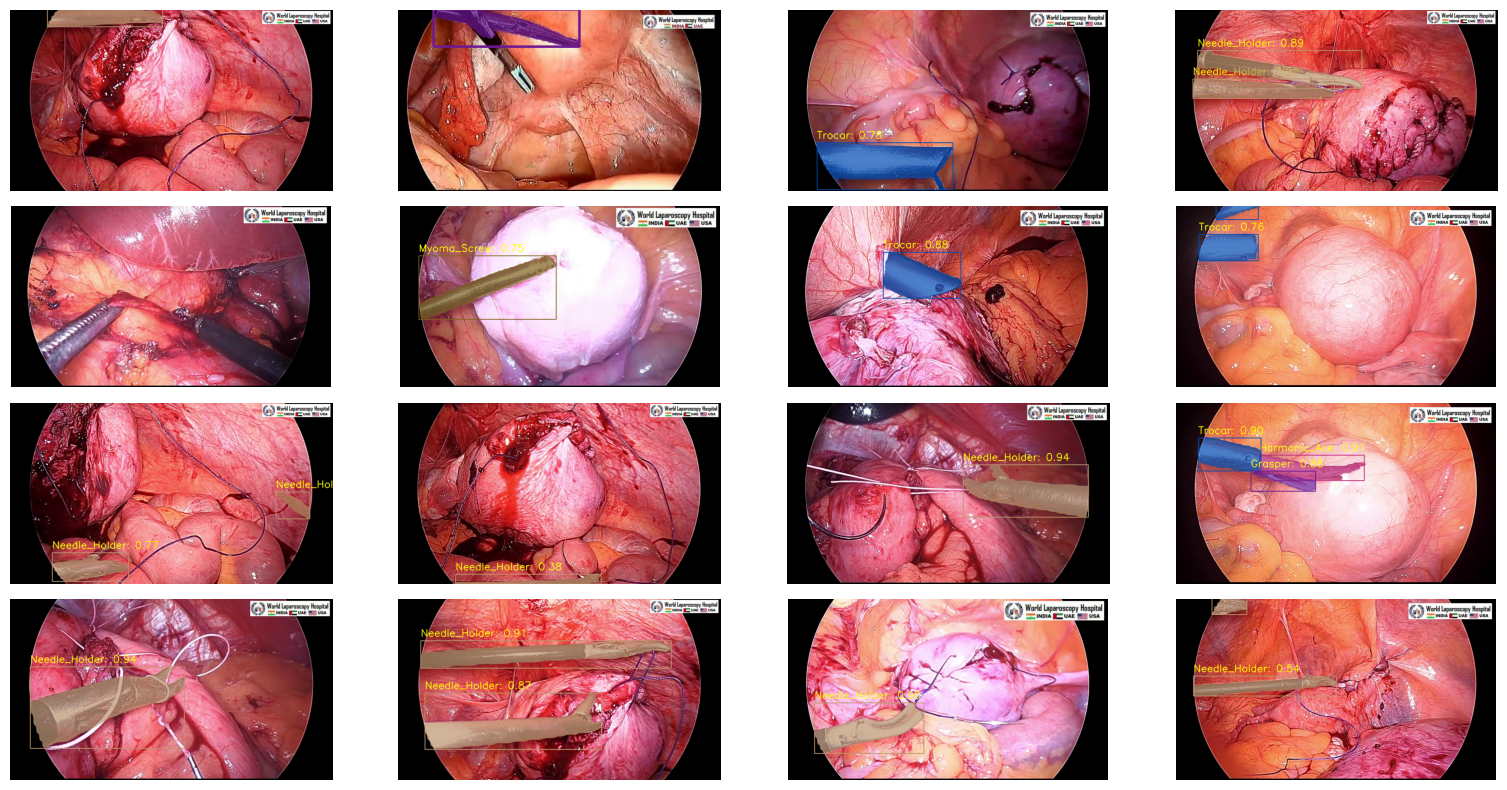

In [86]:
import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
results_dir = "/kaggle/working/SIS-seg-coco/test"

# visualization layout
N = 16
cols = 4
rows = int(np.ceil(N / cols))

# random image selection
all_imgs = [os.path.join(results_dir, f)
            for f in os.listdir(results_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))]

sample_imgs = random.sample(all_imgs, N)

plt.figure(figsize=(4 * cols, 2 * rows))

for i, image in enumerate(sample_imgs):
    plt.subplot(4, 4, i+1)
    plt.subplot(rows, cols, i + 1)
    image_bgr = cv2.imread(image)
    h_orig, w_orig = image_bgr.shape[:2]

    img_resized = cv2.resize(image_bgr, (432, 432))
    img = img_resized.astype(np.float32) / 255.0
    img = img.transpose(2, 0, 1)[None]

    session = onnxruntime.InferenceSession(
        MODEL_PATH, providers=["CPUExecutionProvider"]
    )
    out_boxes, out_logits, out_masks = session.run(
        None, {session.get_inputs()[0].name: img}
    )

    out_boxes = out_boxes[0]     # (200,4) cx,cy,w,h normalized
    out_logits = out_logits[0]   # (200,2) raw logits
    out_masks = out_masks[0]     # (200,108,108) raw logits

    # sigmoid per class (multi-label head)
    cls_probs = sigmoid(out_logits)        # (200,7)
    
    labels = np.argmax(cls_probs, axis=1) + 1
    scores = np.max(cls_probs, axis=1)
    
    valid = np.where(scores > THRESHOLD)[0]
    
    # DETR-style fallback
    if len(valid) == 0:
        valid = np.argsort(scores)[-5:][::-1]

    boxes_nms = []
    scores_nms = []
    labels_nms = []
    
    for idx in valid:
        cx, cy, w, h = out_boxes[idx]
    
        x1 = (cx - w / 2) * w_orig
        y1 = (cy - h / 2) * h_orig
        bw = w * w_orig
        bh = h * h_orig
    
        boxes_nms.append([float(x1), float(y1), float(bw), float(bh)])
        scores_nms.append(float(scores[idx]))
        labels_nms.append(int(labels[idx]))

    keep = cv2.dnn.NMSBoxes(
        boxes_nms,
        scores_nms,
        THRESHOLD,
        IOU_THRESHOLD
    )
    overlay = image_bgr.copy()

    if len(keep) > 0:
        for ii in keep.flatten():
            idx = valid[ii]
            score = scores_nms[ii]
    
            x, y, bw, bh = boxes_nms[ii]
            x1, y1 = max(0, int(x)), max(0, int(y))
            x2 = min(w_orig, int(x + bw))
            y2 = min(h_orig, int(y + bh))
    
            # mask
            m = sigmoid(out_masks[idx])
            m = cv2.resize(m, (w_orig, h_orig))
            m = m > 0.3
    
            bbox_mask = np.zeros_like(m, dtype=bool)
            bbox_mask[y1:y2, x1:x2] = True
            m = np.logical_and(m, bbox_mask)
    
            if m.sum() < 0.01 * (bw * bh):
                continue
    
            cls_id = labels_nms[ii]
            cls_name = CLASS_NAMES[cls_id]
            color = colors[cls_id]
    
            overlay[m] = (
                overlay[m].astype(np.float32) * 0.3 +
                np.array([color], dtype=np.float32) * 0.7
            ).astype(np.uint8)
    
            cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 3)
            cv2.putText(overlay, f"{cls_name}: {score:.2f}", (x1, y1 - 25), cv2.FONT_HERSHEY_SIMPLEX,
                2.0, (0, 255, 255), 4)
        
    combined_img = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    plt.imshow(combined_img)
    plt.axis("off")

plt.tight_layout()
plt.show()